In [52]:
from convokit import Corpus, download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
import pickle as pk
comments = pk.load(open("comments.pk", "rb"))

In [119]:
comments.keys()

dict_keys(['TrueChristian', 'Buddhism', 'Judaism', 'Christianity', 'exchristian', 'RadicalChristianity', 'Catholicism'])

In [122]:
TREATMENT_SUBREDDITS = ['TrueChristian', 'Buddhism', 'Judaism', 'exchristian', 'Catholicism']
BASE_SUBREDDIT = 'Christianity'
K = 50

In [121]:
def conf_interval(data):
    interval = st.norm.interval(confidence=0.95, loc=np.mean(data), scale=st.sem(data))
    return (interval[-1] - interval[0])/2

# Dataset Prep

In [115]:
def prepare_dataset(comments, base_subreddit, treatment_subreddit):
    base_subreddit_comments = comments[base_subreddit][['timestamp', 'text', 'text_len', 'speaker']]
    base_speakers = comments[base_subreddit]['speaker'].unique()
    sub_speakers = comments[subreddit]['speaker'].unique()
    common_speakers = set(base_speakers).intersection(sub_speakers)
    common_speakers = [x for x in common_speakers if x !='[deleted]']
    print(len(common_speakers))

    common_speakers_comments = base_subreddit_comments[base_subreddit_comments['speaker'].isin(common_speakers)].copy()

    first_utts = comments[subreddit].groupby(['speaker'])['timestamp'].min()

    common_speakers_comments['is_before'] = common_speakers_comments.apply(
        lambda row: row['timestamp'] < first_utts[row['speaker']], axis=1
    )

    # select speakers who have at least k comments before and after joining the treatment subreddit
    x = common_speakers_comments[common_speakers_comments['is_before']].groupby("speaker").size() >= K
    before_speakers = x[x].index
    
    x = common_speakers_comments[~common_speakers_comments['is_before']].groupby("speaker").size() >= K
    after_speakers = x[x].index
    
    valid_speakers = set(before_speakers).intersection(set(after_speakers))
    print(len(list(valid_speakers)))
    before = common_speakers_comments[
        (common_speakers_comments['is_before']) 
        & (common_speakers_comments['speaker'].isin(valid_speakers))
    ].copy()
    gb = before.sort_values(['speaker', 'timestamp'], ascending=False).groupby(['speaker'])
    before['order'] = -1 * (gb.cumcount() + 1)

    after = common_speakers_comments[
        (~common_speakers_comments['is_before'])
        & (common_speakers_comments['speaker'].isin(valid_speakers))
    ].copy()
    ga = after.sort_values(['speaker', 'timestamp']).groupby(['speaker'])
    after['order'] = ga.cumcount() + 1

    base_df = pd.concat([before, after])
    return base_df

In [123]:
overlap_speakers_comments = dict()
for subreddit in TREATMENT_SUBREDDITS:
    print(subreddit)
    overlap_speakers_comments[subreddit] = prepare_dataset(comments, base_subreddit, "Buddhism")

TrueChristian
11676
1204
Buddhism
4140
128
Judaism
3392
379
exchristian
4857
250
Catholicism
10968
633


In [192]:
pk.dump(overlap_speakers_comments, open("overlap_speakers_comments.pk", "wb"))

# Analysis

In [ ]:
overlap_speakers_comments = pk.load(open("overlap_speakers_comments.pk", "rb"))

## text_length

In [ ]:
def text_length_pipeline(comments, base_subreddit, subreddit):
    
    
    print('Starting', subreddit)

#     base_df = prepare_dataset(comments, base_subreddit, treatment_subreddit)
    base_df = overlap_speakers_comments[subreddit]
    
    len_avg = comments[subreddit]['text_len'].mean()
    k_only = base_df[base_df['order'].abs() <= k]
    g = k_only.groupby(['order']).agg({'text_len': ['mean', conf_interval]})
    g.columns = g.columns.map(lambda x: '_'.join([str(i) for i in x]))
    g = g.reset_index()

    for i in [5
#               , 10
#               , 20, k/2
             ]:
        g2 = g.groupby(np.arange(len(g))//i).mean()
        g2.plot('order', 'text_len_mean', yerr='text_len_conf_interval')
        plt.axhline(len_avg, color='red', linestyle='--')
        plt.axvline(0, color='grey', linestyle='-')
        plt.title(f"Treatment: joining r/{subreddit}")
        plt.ylim([40, 100])
        plt.savefig(f"{subreddit}-treatment-length.jpg")
    return base_df

Starting TrueChristian
11676
1204
Starting Buddhism
4140
128
Starting Judaism
3392
379
Starting exchristian
4857
250
Starting RadicalChristianity
1455
219
Starting Catholicism
10968
633


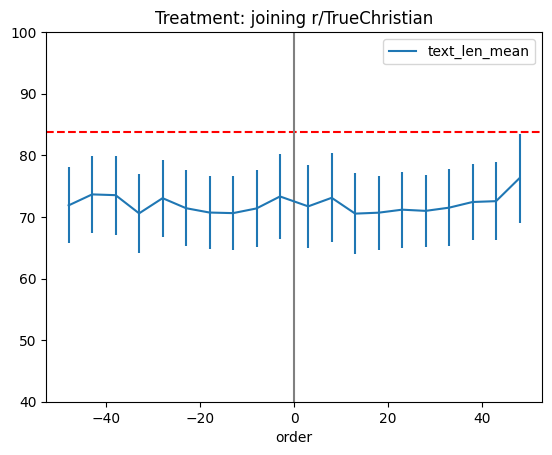

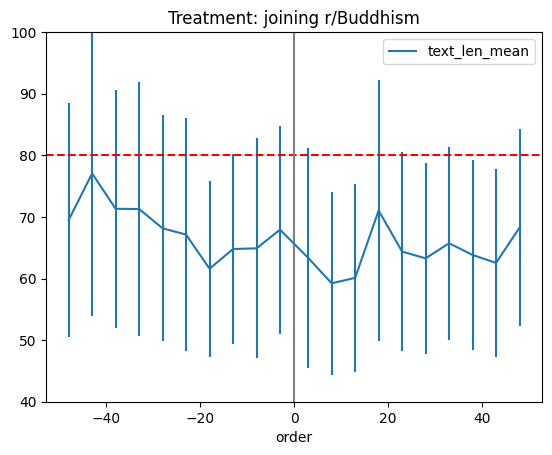

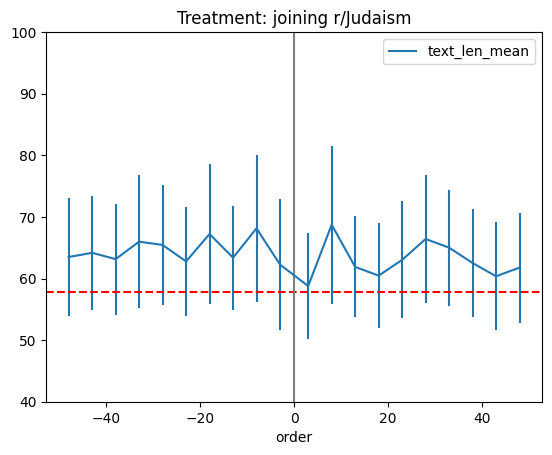

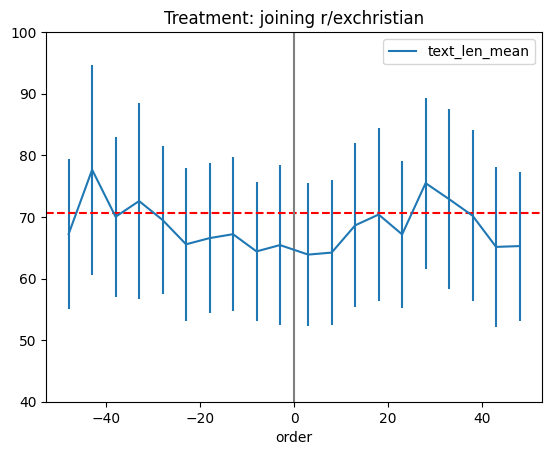

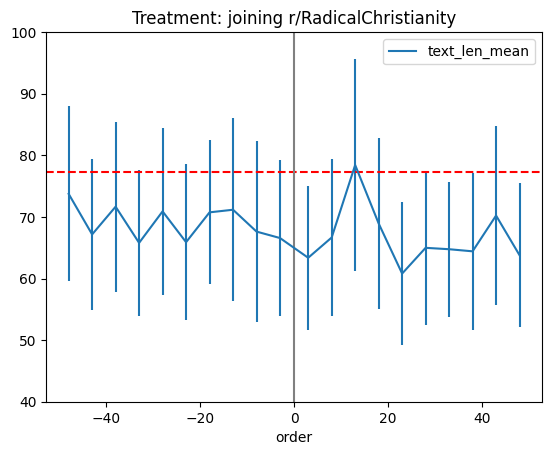

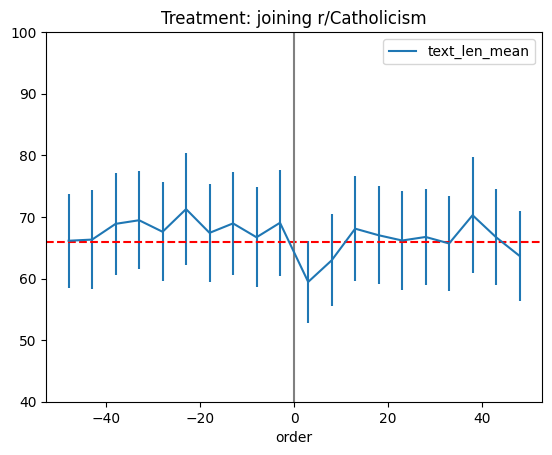

In [113]:
for subreddit in TREATMENT_SUBREDDITS:
    text_length_pipeline(comments, BASE_SUBREDDIT, subreddit)

## cross-entropy

In [190]:
import collections.abc
collections.Hashable = collections.abc.Hashable
from numpy_ml import ngram
from numpy_ml.preprocessing.nlp import tokenize_words, ngrams, strip_punctuation

N = 2 #bigrams

In [161]:
ref_comments_idx = pk.load(open("ref_comments_idx.pk", "rb"))
ref_comments_text = pk.load(open("ref_comments_text.pk", "rb"))

TrueChristian


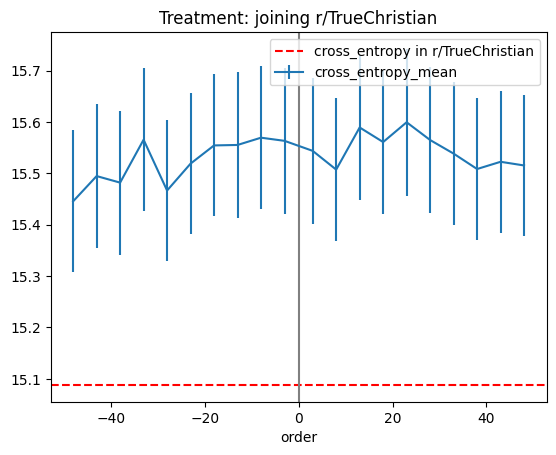

Buddhism


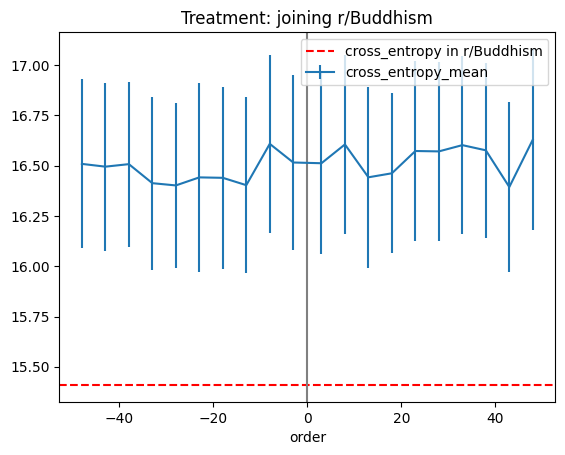

Judaism


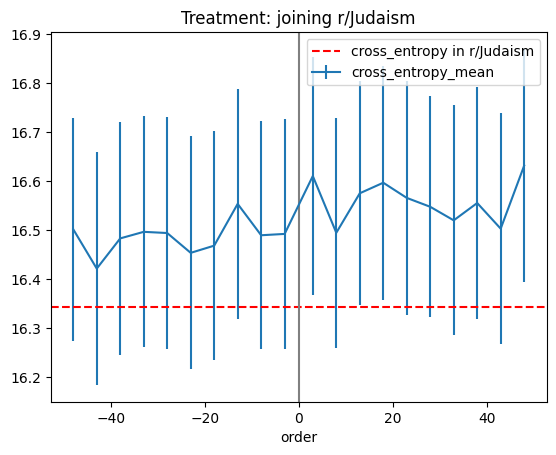

exchristian


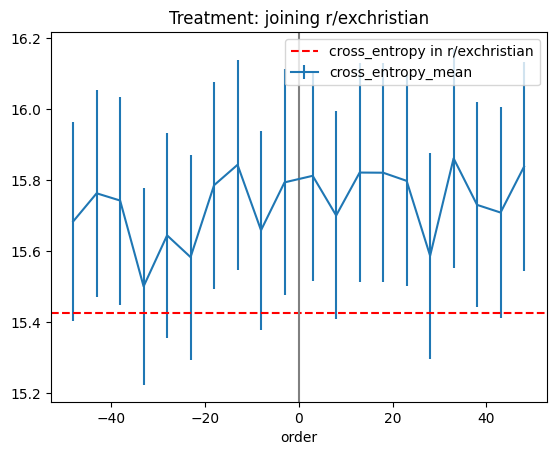

Catholicism


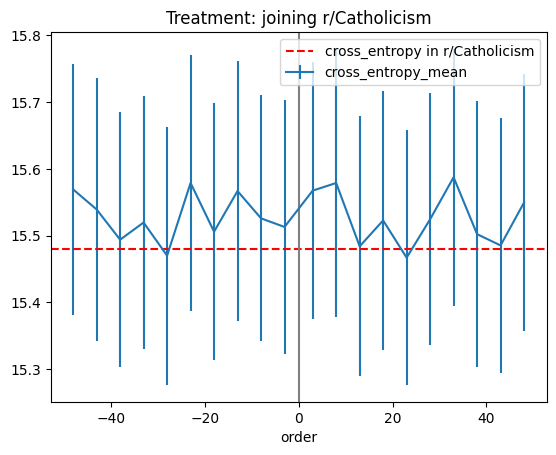

In [191]:
for subreddit in TREATMENT_SUBREDDITS:
    print(subreddit)
    # select base reference from treatment subreddit
    ref_filename = f'./ref-{subreddit}-all.txt'
    with open(ref_filename, mode='wt', encoding='utf-8') as myfile:
        for key in ref_comments_text[subreddit].keys():
            myfile.write('\n'.join(utt.replace("\n", " ") for utt in ref_comments_text[subreddit][key]))

    # train ngram model
    lm = ngram.GoodTuringNGram(N, conf=1.96, unk=True, filter_stopwords=False, filter_punctuation=True)
    lm.train(ref_filename)

    # calculate cross entropy for each order and calculate mean and conf interval
    base_df = overlap_speakers_comments[subreddit]
    k_only = base_df[base_df['order'].abs() <= K].copy()

    def calculate_cross_entropy(text):
        line = strip_punctuation(text)
        words = tokenize_words(line, filter_stopwords=False)
        try:
            cross_entropy = lm.cross_entropy(words, N = N)
            return cross_entropy
        except:
            return None


    k_only['cross_entropy'] = k_only['text'].apply(calculate_cross_entropy)
    ref_idx = [item for sublist in list(ref_comments_idx['Buddhism'].values()) for item in sublist]
    df = comments[subreddit][['text']].reset_index().copy()
    df = df[~df['id'].isin(ref_idx)]
    df['cross_entropy'] = df['text'].apply(calculate_cross_entropy)
    ce_avg = df['cross_entropy'].mean()

    g = k_only.groupby(['order']).agg({'cross_entropy': ['mean', conf_interval]})
    g.columns = g.columns.map(lambda x: '_'.join([str(i) for i in x]))
    g = g.reset_index()
    bin_size = 5
    g2 = g.groupby(np.arange(len(g))//bin_size).mean()
    g2.plot('order', 'cross_entropy_mean', yerr='cross_entropy_conf_interval')
    plt.axhline(ce_avg, color='red', linestyle='--', label=f'cross_entropy in r/{subreddit}')
    plt.axvline(0, color='grey', linestyle='-')
    plt.title(f"Treatment: joining r/{subreddit}")
    plt.legend()
    plt.show()
    #     plt.savefig(f"{subreddit}-treatment-length.jpg")